# IRRmodel\*WCM calibration with PSO on KGE of $\sigma^0$

The v8 code is a final, cleaned and commented version.
This version, wrt to v7, should run faster and be easier to mantain, due to more functions being externally defined and imported, mostly for visualization (plots...).

This version should be the last one to run on notebooks: the goal is to move everything on faster, executables scripts, possibly with in-parallel running, and use the notebooks as test environments.


Possible ideas to implement...
- ET calculated on hourly basis with FAO56-PM
- statistical analysis of parameters to determine correlation between them
- LAI retrieval
- use 2020 database (calibration? validation? ...) [need to solve NDVI issue]
- threshold on KGE and run again to improve estimation of parameters and assess shape of distributions

# Dependencies

In [25]:
import sys
sys.path.append('../')

from modules.funcs import *
from modules.funcs_pso import *
from modules.funcs_plot import *
# from modules.IRRI_WCM_model import *
from modules.EPOT_Hargreaves_pyeto import *

In [26]:
#############################################################################
#############################################################################
# ToDo
#
#############################################################################
#############################################################################


import os
import re
import time
import math
import numpy as np
import pandas as pd
import datetime as dtt
import hydroeval as he

def lin_db(x):
    """linear to dB"""
    return 10*np.log10(x)


def db_lin(x):
    """dB to linear"""
    return 10**(x/10)


def timeseries(dates, data):
    """Returns a matrix (list of type(dates,data)) in the format [dates,data]"""
    
    if len(dates)==len(data):
        return [[dates[i],data[i]] for i in range(len(dates))]
    else: raise ValueError(
        f'dates and data must have same first dimension, but have shapes {np.shape(dates)} and {np.shape(data)}')
    

#############################################################################
# Soil Water Balance + Water Cloud model
#############################################################################

def IRR_WCM(PAR, inputs, user_in):
    """Irrigation model and WCM integration.
    
    Based on minimization of KGE between observed and simulated
    $\sigma^0$ values via PSO (pyswarm) optimization.
    The soil water balance model (IRR) produces an estimate of the soil water
    content WW [%] that is used to simulate $\sigma^0$ by a water cloud
    model (WCM).
    
    Inputs
    ----------
    - PAR: initial guess values for parameters to calibrate
        PAR = [A, B, C, D, W_0, W_max, S_fc, S_w, rho_st, Kc]
    - inputs: input quantities for calibration,
        [d, d_sat, P, IRR_obs, EPOT, WWobs, LAI, t_deg, obs]
    - user_in: user-defined options
        irri = user_in: if user_in=True, irrigation is estimated
        and not taken as an input, else the input observed irrigation
        is used in the soil water balance
    
    Return
    -------
    KGE from hydroeval between sigma0 observed and simulated.
    
    """

    # User input
    irri, units = user_in
    
    # Unpack inputs
    A, B, C, D, W_max = PAR
    t, t_sat, P, IRR_obs, EPOT, WW_obs, WW_sat, veg, angle, sig0_obs = inputs
    
    # Fixed parameters
    global WW_fc  # = 0.32 # 0.32
    global WW_w   # = 0.08 # 0.08
    global rho_st # = 0.4 # /24 # 0.4
    global Kc0    # = 1 # 0.05 # 1
    # global W_max

    W_fc   = WW_fc*W_max # field capacity [mm]
    W_w    = WW_w*W_max # wilting point [mm]
    ET     = np.array([.0]*len(t)) # evapotranspiration
    Ks     = np.array([.0]*len(t)) # water stress coefficient
    rho    = np.array([.0]*len(t)) # depletion fraction
    PS     = np.array([.0]*len(t)) # deep percolation
    W      = np.array([.0]*len(t)) # water content [mm]
    W[0]   = WW_obs[0]*W_max # initial value of sm [mm]    

    if irri==True: IRR = [.0]*len(t) # water content
    else: IRR = IRR_obs
    
    # Build Kc curve
    # Ref. FAO56, Tables 11, 12
    START = t[0].dayofyear; END = t[-1].dayofyear
    START_INI = 134 # first day with vegetation
    L_INI=30; L_IM=40; # length initial and initial to mid stages
    L_MID=45; L_ML=30; # length mid and mid to late stages
    Kc_ini = 0.6*Kc0; Kc_mid = 1.15*Kc0; Kc_late= 0.7*Kc0
    
    # 24 added for compatibility with hourly dataset
    m1 =(Kc_mid-Kc_ini)/L_IM/24 # hourly Kc growth in DEV phase 
    m2 =(Kc_late-Kc_mid)/L_ML/24 # hourly Kc growth in senescence
    
    # Hourly array of Kc values
    Kc_array = np.array([])
    Kc_array = np.append(Kc_array, np.ones((START_INI-START)*24)*Kc_ini)
    Kc_array = np.append(Kc_array, np.ones(L_INI*24)*Kc_ini)
    Kc_array = np.append(Kc_array, [Kc_ini+m1*i for i in range(L_IM*24)])
    Kc_array = np.append(Kc_array, np.ones(L_MID*24)*Kc_mid)
    Kc_array = np.append(Kc_array, [Kc_mid+m2*i for i in range(L_ML*24)])
    Kc_array = np.append(Kc_array, np.ones(len(t)-len(Kc_array))*Kc_late)
    
    for i in [i+1 for i in range(len(t)-1)]:
        
        DOY=t[i].dayofyear
        
        # Build Ks curve
        Kc = Kc_array[i]
        rho[i]=rho_st+0.04*(5-Kc*EPOT[i])
        if W[i-1]>=(1-rho[i])*W_fc:
            Ks[i]=1
        elif (W[i-1]>W_w)and(W[i-1]<(1-rho[i])*W_fc):
            Ks[i]=float(W[i-1]-W_w)/((1-rho[i])*(W_fc-W_w))
        else: Ks[i]=0
        
        # Adjusted evapotranspiration
        ET[i] = EPOT[i]*Kc*Ks[i]
        
        # Irrigation estimate (for summer season only)
        # Irrigation is estimated as the amount of water needed from the day
        # before to take water content up to field capacity
        if irri==True:
            if np.logical_and(DOY>START,DOY<START+100): # summer season
                if W[i-1]<=(1-rho[i])*W_fc: IRR[i]=W_fc-W[i-1]
        
        
        # Water balance [mm]
        W[i]=W[i-1]+P[i]+IRR[i]-ET[i]
        
        # Computation of deep percolation (water above field capacity)
        if W[i]>W_fc:
            PS[i]=W[i]-W_fc
            W[i]=W_fc
            
    WW=np.array(W)/W_max
    WWsat = np.array([ x[1] for x in timeseries(t,WW) if x[0] in t_sat ])
    
    # Water Cloud Model    
    sig0,KGE = WCM([A,B,C,D], [WWsat,veg,angle,sig0_obs], units=units)

    return [WW,IRR,sig0,KGE]


#############################################################################
# Model with all parameters to input by default
#############################################################################

def IRR_WCM_allpar(PAR, inputs, user_in):
    """Irrigation model and WCM integration.
    
    Based on minimization of KGE between observed and simulated
    $\sigma^0$ values via PSO (pyswarm) optimization.
    The soil water balance model (IRR) produces an estimate of the soil water
    content WW [%] that is used to simulate $\sigma^0$ by a water cloud
    model (WCM).
    
    Inputs
    ----------
    - PAR: initial guess values for parameters to calibrate
        PAR = [A, B, C, D, W_0, W_max, S_fc, S_w, rho_st, Kc]
    - inputs: input quantities for calibration,
        [d, d_sat, P, IRR_obs, EPOT, WWobs, LAI, t_deg, obs]
    - user_in: user-defined options
        irri = user_in: if user_in=True, irrigation is estimated
        and not taken as an input, else the input observed irrigation
        is used in the soil water balance
    
    Return
    -------
    KGE from hydroeval between sigma0 observed and simulated.
    
    """

    # User input
    irri, units = user_in
    
    # Unpack inputs
    A, B, C, D, W_max, WW_fc, WW_w, rho_st, Kc0 = PAR
    d, d_sat, P, IRR_obs, EPOT, W_d, W_h, veg, angle, sig0_obs = inputs
    
    # Fixed parameters
    W_0    = W_d[0]
    
    theta  = angle*np.pi/180. # angle of incidence
    W_fc   = WW_fc*W_max # field capacity [mm]
    W_w    = WW_w*W_max # wilting point [mm]
    Ks     = [0]*len(d) # daily, water stress coefficient
    rho    = [0]*len(d) # daily, depletion fraction
    PS     = [0]*len(d) # daily, deep percolation
    W      = [0]*len(d) # daily, water content [mm]
    W[0]   = W_0*W_max # initial value of sm [mm]
    if irri==True: IRR = [0]*len(d) # daily, water content
    else: IRR = IRR_obs
    
    for t in [i+1 for i in range(len(d)-1)]:
        
        DOY=d[t].dayofyear
        
        # Build Kc curve
        # Ref. FAO56, Tables 11, 12
        START  = 134
        Kc_ini = 0.6*Kc0
        Kc_mid = 1.15*Kc0
        Kc_late= 0.7*Kc0

        INI =[x for x in range(START, START+30)] # initial phenological phase
        DEV =[x for x in range(START+30, START+30+40)] # development phase
        m1  =(Kc_mid-Kc_ini)/40 # daily Kc growth in DEV phase 
        MID =[x for x in range(START+30+40, START+30+40+45)] # mid phase
        LATE=[x for x in range(START+30+40+45, START+30+40+45+30)] # late stage
        m2  =(Kc_late-Kc_mid)/30 # daily Kc growth in senescence
        
        if DOY in INI: Kc=Kc_ini
        elif DOY in DEV: Kc=Kc_ini+m1*(DOY-DEV[0])
        elif DOY in MID: Kc=Kc_mid
        elif DOY in LATE: Kc=Kc_mid+m2*(DOY-LATE[0])
        elif DOY>LATE[-1]: Kc=Kc_late
        else: Kc=Kc_ini
        
        # Build Ks curve
        rho[t]=rho_st+0.04*(5-Kc*EPOT[t])
        if W[t-1]>=(1-rho[t])*W_fc:
            Ks[t]=1
        elif (W[t-1]>W_w)and(W[t-1]<(1-rho[t])*W_fc):
            Ks[t]=float(W[t-1]-W_w)/((1-rho[t])*(W_fc-W_w))
        else: Ks[t]=0
        
        # Irrigation estimate (for summer season only)
        # Irrigation is estimated as the amount of water needed from the day
        # before to take water content up to field capacity
        if irri==True:
            if np.logical_and(DOY>START,DOY<START+100): # summer season
                if W[t-1]<=(1-rho[t])*W_fc: IRR[t]=W_fc-W[t-1]
        
        # Water balance [mm]
        W[t]=W[t-1]+P[t]+IRR[t]-EPOT[t]*Kc*Ks[t]
        
        # Computation of deep percolation (water above field capacity)
        if W[t]>W_fc:
            PS[t]=W[t]-W_fc
            W[t]=W_fc
            
    WW=np.array(W)/W_max
    WWsat = np.array([ x[1] for x in timeseries(t,WW) if x[0] in t_sat ])
    
    # Water Cloud Model    
    sig0,KGE = WCM([A,B,C,D], [WWsat,veg,angle,sig0_obs], units=units)

    return [WW,IRR,sig0,KGE]



#############################################################################
# Water Cloud Model #############################################################################

def WCM(PAR, data_in, units='lin'):
    """Water Cloud Model.
    
    This function simulates backscattering with WCM and returns
    the KGE index to perform its minimization for calibration
    of parameters A,B,C,D.
    WCM is parametrized with a single vegetation descriptor (nominated
    LAI, but can be anything).
    Fitting can be performed in linear or dB scale.
    The model is written in one line in both units: this makes the calibration slightly slower, but provides more stability in the parameters' distributions.
    
    
    Inputs
    ------
    - PAR: list
        List of initial guesses for the parameters to calibrate.
    - data_in: list
        List of inputs of observables, that must be in the form:
        [SM,LAI,t_deg,obs], being SM = soil moisture,
        LAI = Leaf Area Index, t_deg = angle of observation,
        obs = observed total sigma0
    - units: str, default 'linear'
        choose to calibrate the model's parameters in 'linear' or 'db' scale
        
    Return
    ------
    KGE between simulated and observed backscattering.
    
    """

    A,B,C,D = PAR # parameters to fit
    WWsat,veg,angle,obs = data_in # input data
    
    theta  = angle*np.pi/180. # angle of incidence
    
    if units=='lin':
        sig0 = lin_db((np.exp((-2*B*veg)/np.cos(theta)))*(db_lin(C+D*WWsat))\
                      +A*veg*np.cos(theta)\
                      *(1-(np.exp((-2*B*veg)/np.cos(theta)))))
    elif units=='db':
        sig0 = (np.exp((-2*B*veg)/np.cos(theta)))*(C+D*WWsat)\
        +(A*veg*np.cos(theta)\
          *(1-(np.exp((-2*B*veg)/np.cos(theta)))))
    else: raise NameError('Please choose one of the options: lin/db')
        
    OUT=he.evaluator(he.kge, sig0, obs) # OUT is kge, r, alpha, beta
    KGE=OUT[0,:][0]

    return [sig0,KGE]

#----------------------------------------------------------------------------

def SM_fromWCM(PAR, data_in, units='lin'):
    """Inverted WCM for SM estimation."""

    A,B,C,D = PAR # parameters, fitted
    WWsat,veg,angle,obs = data_in # input data
    
    theta = angle*np.pi/180. # angle of observation
    T2 = np.exp((-2*B*veg)/np.cos(theta)) # attenuation
    sig0v = A*veg*np.cos(theta)*(1-T2) # sigma0_veg
    
    if units=='lin':
        sig0s_lin = (db_lin(obs)-sig0v)/T2
        SMretr = (lin_db(sig0s_lin)-C)/D
    elif units=='db':
        sig0s = (obs-sig0v)/T2
        SMretr = (sig0s-C)/D 
    
    OUT=he.evaluator(he.kge, SMretr, WWsat) # OUT is kge, r, alpha, beta
    KGE=OUT[0,:];

    return [SMretr,KGE]



#############################################################################
# Soil Water Balance
#############################################################################

def SWB(PAR_SWB, inputs, user_in):
    """Soil water balance + irrigation estimation model .
    
    The soil water balance model (IRR) produces an estimate of the soil water
    content WW [%] and irrigation requirement IRR [mm].
    Ref: Rolle, 2021
    
    Inputs
    ----------
    - PAR: initial guess values for parameters to calibrate
        PAR = [A, B, C, D, W_0, W_max, S_fc, S_w, rho_st, Kc]
    - inputs: input quantities for calibration,
        [d, d_sat, P, IRR_obs, EPOT, WWobs, LAI, t_deg, obs]
    - user_in: user-defined options
        irri = user_in: if user_in=True, irrigation is estimated
        and not taken as an input, else the input observed irrigation
        is used in the soil water balance
    
    Return
    -------
    [WW, IRR]: simulated water content and irrigation requirement 
    
    """

    # User input
    irri, units = user_in
    
    # Unpack inputs
    W_max, WW_fc, WW_w, rho_st, Kc0 = PAR_SWB
    d, P, IRR_obs, EPOT, W_d = inputs
    
    # Fixed parameters
    # global WW_fc  # = 0.32 # 0.32
    # global WW_w   # = 0.08 # 0.08
    # global rho_st # = 0.4 # /24 # 0.4
    # global Kc0    # = 1 # 0.05 # 1
    W_0 = W_d[0]
    
    W_fc   = WW_fc*W_max # field capacity [mm]
    W_w    = WW_w*W_max # wilting point [mm]
    Ks     = [0]*len(d) # daily, water stress coefficient
    rho    = [0]*len(d) # daily, depletion fraction
    PS     = [0]*len(d) # daily, deep percolation
    W      = [0]*len(d) # daily, water content [mm]
    W[0]   = W_0*W_max # initial value of sm [mm]
    if irri==True: IRR = [0]*len(d) # daily, water content
    else: IRR = IRR_obs
    
    for t in [i+1 for i in range(len(d)-1)]:
        
        DOY=d[t].dayofyear
        
        # Build Kc curve
        # Ref. FAO56, Tables 11, 12
        START  = 134 # 14 May
        Kc_ini = 0.6*Kc0
        Kc_mid = 1.15*Kc0
        Kc_late= 0.7*Kc0

        INI =[x for x in range(START, START+30)] # initial phenological phase
        DEV =[x for x in range(START+30, START+30+40)] # development phase
        m1  =(Kc_mid-Kc_ini)/40 # daily Kc growth in DEV phase 
        MID =[x for x in range(START+30+40, START+30+40+45)] # mid phase
        LATE=[x for x in range(START+30+40+45, START+30+40+45+30)] # late stage
        m2  =(Kc_late-Kc_mid)/30 # daily Kc growth in senescence
        
        if DOY in INI: Kc=Kc_ini
        elif DOY in DEV: Kc=Kc_ini+m1*(DOY-DEV[0])
        elif DOY in MID: Kc=Kc_mid
        elif DOY in LATE: Kc=Kc_mid+m2*(DOY-LATE[0])
        elif DOY>LATE[-1]: Kc=Kc_late
        else: Kc=Kc_ini
        
        # Build Ks curve
        rho[t]=rho_st+0.04*(5-Kc*EPOT[t])
        if W[t-1]>=(1-rho[t])*W_fc:
            Ks[t]=1
        elif (W[t-1]>W_w)and(W[t-1]<(1-rho[t])*W_fc):
            Ks[t]=float(W[t-1]-W_w)/((1-rho[t])*(W_fc-W_w))
        else: Ks[t]=0
        
        # Irrigation estimate (for summer season only)
        # Irrigation is estimated as the amount of water needed from the day
        # before to take water content up to field capacity
        if irri==True:
            if np.logical_and(DOY>START,DOY<START+100): # summer season
                if W[t-1]<=(1-rho[t])*W_fc: IRR[t]=W_fc-W[t-1]
        
        # Water balance [mm]
        W[t]=W[t-1]+P[t]+IRR[t]-EPOT[t]*Kc*Ks[t]
        
        # Computation of deep percolation (water above field capacity)
        if W[t]>W_fc:
            PS[t]=W[t]-W_fc
            W[t]=W_fc
            
    WW=np.array(W)/W_max

    return [WW,IRR]



#############################################################################
# Snippets and old versions of the code
#############################################################################

    # Water Cloud Model
    # Multi-line, double units version
    #---------------------------------
    # sig0s_dB = C+D*WWsat # sigma0_soil [dB]
    # T2 = np.exp((-2*B*veg)/np.cos(angle)) # attenuation
    # sig0v = A*veg*np.cos(angle)*(1-T2) # sigma0_veg [units]
    # 
    # if units=='lin':
    #     sig0s = db_lin(sig0s_dB) # sigma0_soil [lin]
    #     sig0_lin = T2*sig0s+sig0v # sigma0_tot [lin]
    #     sig0=lin_db(sig0_lin) # sigma0_tot [dB]
    # elif units=='db':
    #     sig0 = T2*sig0s_dB+sig0v # sigma0_tot [db]
    # else: raise NameError('Please choose one of the options: lin/db')
    
    
    # Old method for WW_sat cut on d_sat dates
    #-----------------------------------------
    # WWsat = pd.DataFrame(timeseries(d,WW))\
    #           .set_index(0).loc[d_sat][1].values

# Data pre-processing

Input data formatting convention:
- ausiliary variables for extraction of data (directory name, file name, etc...)
- extraction into pd dataframe
- cleaning, resampling: drop unnecessary columns, set index to daily DateIndex

**Time resampling consistency**

- $\sigma^0$ values are extracted with a timestamp aaaa-mm-dd hh:mm:ss with frequency 'H' (hourly), then are rounded by `.round()` to the midnight of the nearest day to have frequency 'D' (daily), e.g. a passage at 7 am on 1st july is rounded to 0 am of 1st july, a passage at 7 pm would be rounded at 0 am of 2nd july.
- many quantities need to be resampled from hourly to daily datasets: use the `.resample()` method on a dataframe with hourly DatetimeIndex and pass the argument `origin='end_day'`. In this way, for each day X, data are considered between hours 1 and 24(=0 of day X+1) and the timestamp assigned is the one of the day X+1 (on which the operation ends). 

In [27]:
print('Starting...\n'
      +'#-------------------------------------------------------------\n'
      #+'Use of satellite-derived SM is provided for comparison, not calibration.\n'
     )
verbose = True if input("Verbose data extraction? (Describe datasets/files) [y/n]")=='y' else False

params = []; norma = ''

print('\n#-------------SWB model parameters-------------')
irri = True if input('Do you want to estimate irrigation as well as soil moisture? [y/n]')=='y' else False
year = int(input('Do you want to calibrate on year 2017 or 2020? [2017/2020]'))
freq = input('Daily or hourly frequency? [d/h]')

print('\n#-------------WCM model parameters-------------')
units = input('Calibrate WCM in linear or dB scale (determines scale of A)? [lin/db]')
opt_veg = 'NDVI'

print('\n#------------Optimization parameters-----------')
opt_calib = 'sigma0'
opt_cost = 'KGE'

PAR_str_add = input('Any addition to parameters\' names? [Type string to add]')
nrun = int(input('Number of runs? (10 is min to study distribution of parameters.) '))
n_particles = int(input('Number of particles: '))
n_step = int(input('Number of optimization steps: '))
optim = input('Global or Local PSO optimizer? [[global]/local] ')
if optim=='local': norma = 1 if input('Which norm? [l1/l2] ')=='l1' else 2
verbose_calib = True if input('Verbose during calibration? [y/n]')=='y' else False
automate = True if input('Run and save everything automatically? [y/n]')=='y' else False

Starting...
#-------------------------------------------------------------



Verbose data extraction? (Describe datasets/files) [y/n] n



#-------------SWB model parameters-------------


Do you want to estimate irrigation as well as soil moisture? [y/n] n
Do you want to calibrate on year 2017 or 2020? [2017/2020] 2017
Daily or hourly frequency? [d/h] h



#-------------WCM model parameters-------------


Calibrate WCM in linear or dB scale (determines scale of A)? [lin/db] lin



#------------Optimization parameters-----------


Any addition to parameters' names? [Type string to add] 
Number of runs? (10 is min to study distribution of parameters.)  50
Number of particles:  20
Number of optimization steps:  200
Global or Local PSO optimizer? [[global]/local]  
Verbose during calibration? [y/n] n
Run and save everything automatically? [y/n] y


## IRRmodel

Frequency: daily

Inputs:
- rain (sum, end of day)
- et0 (daily)

Comparisons:
- irrigation (sum, end of day)
- soil moisture (mean, end of day)

In [28]:
#----------------------------------------------------------------------------
# Budrio field data from platinum_df tables

# Freq: H
# Data extracted:
# - SWC (as input SWB/comparison)
# - rain (as input SWB)
# - irrigation (as input SWB)
# - temperature (as input SWB, ET0 estimate)

platinum_df = pd.ExcelFile('..\Inputs\Platinum_Budrio.xlsx', engine='openpyxl')
if year==2017: sheet='2017_1h'
if year==2020: sheet='2020_1h'
platinum_df = platinum_df.parse(sheet)
# platinum_df = pd.concat([platinum_df.parse('2017_1h'), platinum_df.parse('2020_1h')])

# Column 'Date' contains date+hour = hourly information
# Column 'Data' contains only date = daily information
platinum_df['Ora_1'] = pd.to_datetime(platinum_df['Ora'].astype('str')).apply(lambda x: x.time())
platinum_df['Data_1'] = pd.to_datetime(platinum_df['Data'].astype('str')).apply(lambda x: x.date())
platinum_df['Datetime'] = platinum_df.apply(lambda r : dtt.datetime.combine(r['Data_1'],r['Ora_1']),1)
platinum_df = platinum_df.drop(['ID', 'Data', 'Ora', 'Data_1', 'Ora_1', '214Pb[cps]'],axis=1)
platinum_df = platinum_df.set_index('Datetime')
platinum_resampled = platinum_df.resample('D', origin='end_day')
if verbose: platinum_df.info()

In [29]:
lat_deg = 44.570842547510622 # latitude of Budrio (deg)
temp_min = platinum_resampled.min()['Temperatura[°C]'].values
temp_max = platinum_resampled.max()['Temperatura[°C]'].values
temp_mean = platinum_resampled.mean()['Temperatura[°C]'].values
dates = platinum_resampled.asfreq().index
eto = timeseries( dates,
                 [ hargre(lat_deg, dates[i] , temp_min[i], temp_max[i], temp_mean[i])
                  for i in range(len(dates)) ] )
eto_df = pd.DataFrame(eto).rename(columns={0:'Date',1:'EPOT'}).set_index('Date')
if verbose: eto_df.info()

## WCM

Frequency: multi-daily

Inputs:
- $\sigma^0$, $\theta$ (hourly, rounded to nearest midnight)
- vegetation descriptors (NDVI, LAI, CR) (average, daily)

In [30]:
#----------------------------------------------------------------------------
# Sigma0 values

# Freq: D
# Daily values of backscattering from 2014 to 2022 (complete S1 series)
# Data extracted:
# - sigma0 values, VV and VH
# - angle of incidence of reference orbit (nearest to 40°)

sigma_df = pd.read_csv('..\Data\\budrio-half.csv', delimiter='\t');
sigma_df['Datetime'] = sigma_df.Date.apply(lambda x : pd.to_datetime(x))
angle_mean_95 = sigma_df.loc[sigma_df.Orb==95]['Angle[°]'].mean()
sigma_df['Angle[°]'] = sigma_df['Angle[°]'].apply(lambda x : angle_mean_95)
sigma_df.Date = sigma_df.Date.apply(lambda x : pd.to_datetime(x).round(freq='D'))
sigma_df = sigma_df.set_index('Date')
if verbose: sigma_df.info()

In [31]:
#----------------------------------------------------------------------------
# NDVI values

# Freq: D
# Daily values of NDVI from 2017-4-24 to 2023-1-13 (complete S2 series)
# Data extracted:
# - NDVI (daily, interpolated)

ndvi_df = pd.read_csv('..\Data\\budrio-half_NDVI.csv', delimiter='\t');
ndvi_df.Date = ndvi_df.Date.apply(lambda x : pd.to_datetime(x))
ndvi_df = ndvi_df.set_index('Date')
if verbose: ndvi_df.info()

# Input data

In [32]:
# Input SWB
# Frequency: daily
# Data:
# - rain (sum, end of day) from platinum_resampled
# - eto (daily) from eto_df

if freq=='d':
    input_swb = pd.merge(right=eto_df, left=platinum_resampled.sum(),
                     right_on='Date', left_on='Datetime', right_index=True)\
                    .drop(['SWC[m3/m3]','Temperatura[°C]'], axis=1)
    input_swb['SWC[m3/m3]'] = platinum_resampled.mean()['SWC[m3/m3]']
    if verbose: input_swb.info()

# Input SWB
# Frequency: hourly
# Data:
# - rain (hourly) from platinum_df, linear interpolation
# - irrigation (hourly) from platinum_df
# - eto (daily) from eto_df, up-resampled hourly with linear interpolation

elif freq=='h':
    eto_df_h = eto_df.resample('H').asfreq().interpolate(method='linear')
    input_swb = pd.merge(right=eto_df_h, left=platinum_df,
                         right_on='Date', left_on='Datetime', right_index=True)\
                        .drop(['Temperatura[°C]'], axis=1)
    input_swb['Pioggia[mm]'].interpolate(method='linear',inplace=True)
    if verbose: input_swb.info()

In [33]:
# Input WCM
# Frequency: daily
# Data:
# - sigma0 (multi-daily, rounded at nearest midnight)
# - NDVI (daily, interpolated)
# Merging is performed without any time offset, considering that the change
# in ndvi values anywhere is very small from one day to another 

input_wcm_sat = pd.merge(right=sigma_df, left=ndvi_df, on='Date', how='right')
input_wcm_sat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1150 entries, 2014-10-12 to 2022-11-28
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   NDVI         916 non-null    float64       
 1   Geometry_x   916 non-null    object        
 2   Angle[°]     1150 non-null   float64       
 3   Geometry_y   1150 non-null   object        
 4   Orb          1150 non-null   int64         
 5   Pass         1150 non-null   object        
 6   VV_norm[dB]  1150 non-null   float64       
 7   VH_norm[dB]  1150 non-null   float64       
 8   CR           1150 non-null   float64       
 9   Datetime     1150 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 98.8+ KB


In [34]:
input_wcm = pd.merge(right=input_wcm_sat, left=platinum_df, on='Datetime',
                     how='inner')\
            .drop(['Pioggia[mm]','Irrigazione[mm]','Temperatura[°C]',
                   'Geometry_x'], axis=1)\
            .rename(columns={'SWC[m3/m3]':'SWC_h', 'Geometry_y':'Geometry',
                             'VV_norm[dB]':'VV', 'VH_norm[dB]':'VH', 'Angle[°]':'Angle'})

#----------------------------------------------------------------------------
# Convenience method for printing labels of columns that are interpolated
# only on the basis of their length being less than the length of the df,
# and not taking into consideration if they are being interpolated or extr

# print('The following columns will be interpolated: '
#       +f'{[x for x in input_wcm if len(input_wcm[x].dropna())<len(input_wcm)]}\n')
# if input('Proceed? [y/n]')!='y':
#      raise NameError('Stop and stare! I think I\'m going but I don\'t know where!')
#----------------------------------------------------------------------------

print(
    '\nNDVI values are limited below at the 24 of april 2017, so they are'+
    'backward propagated for 30 days in order to cover the whole Budrio period.'+
    ' There is a gap in SWC values: this gap is not interpolated but is used to'+
    'eliminate those days with nan SM values from the days of passage of the'+
    'satellite.\n'
)
input_wcm.NDVI.interpolate(method='bfill',
                           limit_direction='backward',
                           limit=30,
                           # limit_area='inside', # THIS WORKS VERY BADLY IN EVERY WAY
                           inplace=True)
if freq=='d': input_wcm.index = input_wcm.Datetime.round('D')
elif freq=='h': input_wcm.index = input_wcm.Datetime
input_wcm.dropna(inplace=True)
if verbose: input_wcm.info()


NDVI values are limited below at the 24 of april 2017, so they arebackward propagated for 30 days in order to cover the whole Budrio period. There is a gap in SWC values: this gap is not interpolated but is used toeliminate those days with nan SM values from the days of passage of thesatellite.



In [35]:
# List of 2017 and 2020 dates

# Complete days in 2017, 2020
t = [x for x in input_swb.index if x.year==year]
     
# Days of passage of satellite, intersect with complete days
set1 = {x for x in input_swb.index}; set2 = {x for x in input_wcm.index};
intersect = np.sort(np.array([*set1.intersection(set2)]))
t_sat = [x for x in intersect if x.year==year]

In [36]:
P       = input_swb.loc[t]['Pioggia[mm]'].values # [mm]
IRR_obs = input_swb.loc[t]['Irrigazione[mm]'].values # [mm]
EPOT    = input_swb.loc[t]['EPOT'].values # [mm/day]
WW_obs  = input_swb.loc[t]['SWC[m3/m3]'].values # daily mean or hourly, with gaps
WW_sat  = input_wcm.loc[t_sat]['SWC_h'].values # punctual at hour (observed) [m3/m3]
veg     = input_wcm.loc[t_sat]['NDVI'].values # [-]
angle   = input_wcm.loc[t_sat]['Angle'].values # [°]
VV      = input_wcm.loc[t_sat]['VV'].values # [dB]
VH      = input_wcm.loc[t_sat]['VH'].values # [dB]
CR      = input_wcm.loc[t_sat]['CR'].values # [-]

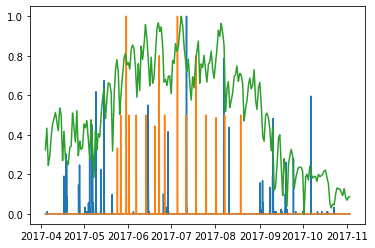

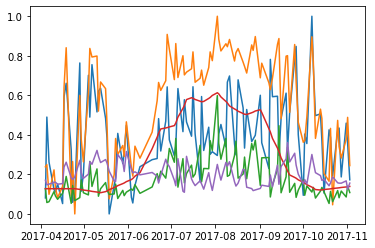

In [37]:
for x in [P,IRR_obs,EPOT,WW_obs]: plt.plot(t, norm(x))
plt.show()
for x in [norm(VV),norm(VH),CR,veg,WW_sat]: plt.plot(t_sat,x)
plt.show()

# Calibration SWB+WCM

In [38]:
def pso_calib_irri(PAR):
    """Ausiliary function for PSO optimization"""
    global inputs
    global user_in
    n_particles = PAR.shape[0]
    err = np.zeros(n_particles)
    for i in range(n_particles):
        WW,IRR,sig0,KGE = IRR_WCM(PAR[i], inputs, user_in)
        err[i] = 1 - KGE
    return err

In [76]:
# Calibration SWB+WCM

print('Starting calibration...\n'+
      '#-------------------------------------------------------------\n')

A=0.3; B=1.5; C=-15; D=30 # guess params for WCM
W_max=    100;   # [mm] water content, maximum (not normalized)
WW_fc=    0.32; # [m3/m3] water content at field capacity
WW_w=     0.08; # [m3/m3] water content at wilting point
rho_st=   0.4;  # [-] crop specific depletion fraction
Kc0=      1;  # [-] crop specific coefficient
if freq=='h': rho_st/=24; Kc0/=24

# PAR default
PAR_str = ['A', 'B', 'C', 'D', 'W_max', 'WW_fc', 'WW_w', 'rho_st', 'Kc0']
if units=='db': PAR_str = [el + '_db' for el in PAR_str]

# PAR to calibrate
# A, B, C, D, W_max, WW_fc, WW_w, rho_st, Kc0
PAR     = [A, B, C, D, W_max]
PARn_str= ['A', 'B', 'C', 'D', 'W_max']
inputs  = [t, t_sat, P, IRR_obs, EPOT, WW_obs, WW_sat, veg, angle, VV]
user_in = [irri, units]

if units=='lin':
    bounds = (
        np.array([0.01,0.1,-30, 10,   1]), # low
        np.array([1,   3,   -5,100, 100]),  # up
    )
elif units=='db':
    bounds = (
        np.array([ -20,0.1,-30, 10,   1, 0.3, 0.01,]), # low
        np.array([ -10,3,   -5,100, 150, 0.5, 0.2, ]),  # up
    )
#     bounds = (
#         np.array([0.01,0.1,-30, 10,   1, 0.3, 0.01,0.01, 0.001]), # low
#         np.array([1,   3,   -5,100, 150, 0.5, 0.2, 0.8,  1]),  # up
#     )
else: raise NameError(f'Scale can only be lin or db but {scale} was provided.')

#-----------------------------------------------------------------------------
from pyswarms.backend.handlers import OptionsHandler

params = []
start = time.time()
for i in range(int(nrun)):
    
    print('Run number ', i+1)
    if (optim=='global')or(optim==''):
        optim='global'
        # options = {'c1': 0.5, 'c2': 0.9, 'w': 0.6}
        options = {'c1': 2.05, 'c2': 2.05, 'w': 0.6}
        oh_strategy = {"w":'exp_decay', 'c1':'lin_variation', 'c2':'lin_variation'}
        optimizer = ps.single.GlobalBestPSO(n_particles=int(n_particles),
                                            dimensions=len(PAR),
                                            options=options,
                                            bounds=bounds,
                                            oh_strategy=oh_strategy,
                                           )
    elif optim=='local':
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8, 'k':int(0.1*n_particles), 'p':norma }
        optimizer = ps.single.LocalBestPSO(n_particles=n_particles,
                                           dimensions=len(PAR),
                                           options=options,
                                           bounds=bounds,
                                           oh_strategy={"w":'exp_decay',
                                                         'c1':'lin_variation',
                                                         'c2':'lin_variation'})
    else: raise NameError('Please provide an accepted option.')
    
    cost, PARn = optimizer.optimize(pso_calib_irri, n_step, verbose=verbose_calib)#, **PAR)
    params.append(PARn)
    end = time.time()
    if i==0:
        time_sec = round(end-start, 2)
        time_min =  round((end-start)/60, 2)
        print(time_min, ' min for last run,', time_min*nrun , ' min estimated')
    print('Time left: ', round((start+time_sec*nrun-end)/60,2), 'min')

timestr = time.strftime("%y%m%d-%H%M%S"); print('Timestring: ', timestr)

Starting calibration...
#-------------------------------------------------------------

Run number  1
2.46  min for last run, 123.0  min estimated
Time left:  120.49 min
Run number  2
Time left:  118.07 min
Run number  3
Time left:  115.68 min
Run number  4
Time left:  113.27 min
Run number  5
Time left:  110.82 min
Run number  6
Time left:  108.39 min
Run number  7
Time left:  105.95 min
Run number  8
Time left:  103.51 min
Run number  9
Time left:  101.07 min
Run number  10
Time left:  98.64 min
Run number  11
Time left:  96.22 min
Run number  12
Time left:  93.78 min
Run number  13
Time left:  91.33 min
Run number  14
Time left:  88.9 min
Run number  15
Time left:  86.47 min
Run number  16
Time left:  84.03 min
Run number  17
Time left:  81.59 min
Run number  18
Time left:  79.15 min
Run number  19
Time left:  76.74 min
Run number  20
Time left:  74.3 min
Run number  21
Time left:  71.86 min
Run number  22
Time left:  69.42 min
Run number  23
Time left:  66.99 min
Run number  24
Tim

In [77]:
print('Timing: ', round((end-start)/60/nrun, 2), ' min for 1 run,', round((end-start)/60, 2), 'min total')

Timing:  2.41  min for 1 run, 120.3 min total


# Parameters' study

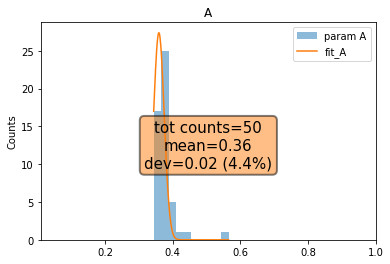

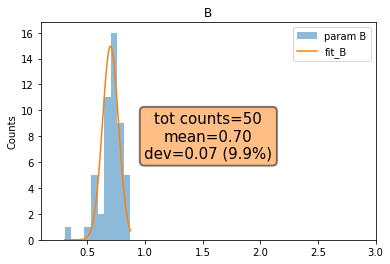

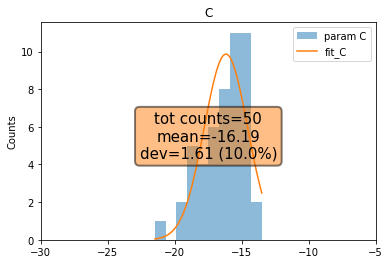

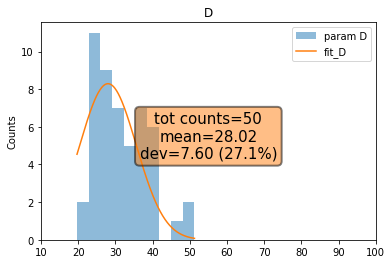

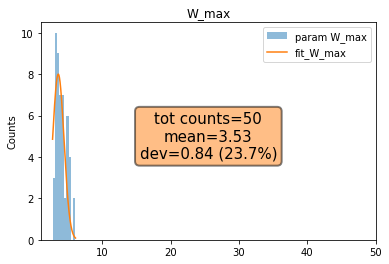

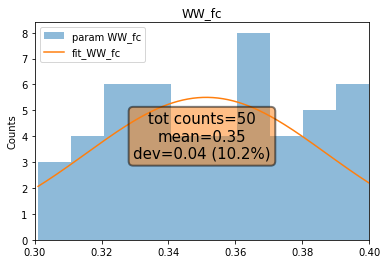

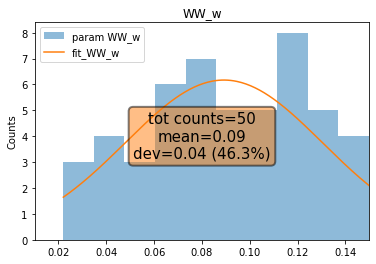

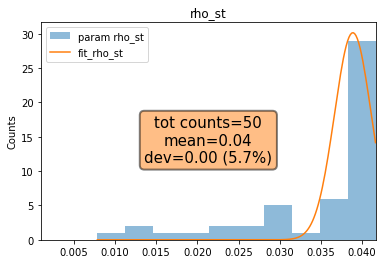

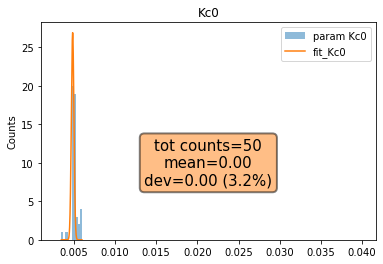

{'A': [0.3, 'cal', [0.01, 1.0], 0.359, 0.016],
 'B': [1.5, 'cal', [0.1, 3.0], 0.702, 0.07],
 'C': [-15, 'cal', [-30.0, -5.0], -16.187, 1.614],
 'D': [30, 'cal', [10.0, 100.0], 28.024, 7.597],
 'W_max': [100, 'cal', [1.0, 50.0], 3.534, 0.837],
 'WW_fc': [0.32, 'cal', [0.3, 0.4], 0.351, 0.036],
 'WW_w': [0.08, 'cal', [0.01, 0.15], 0.089, 0.041],
 'rho_st': [0.02, 'cal', [0.0, 0.04], 0.039, 0.002],
 'Kc0': [0.04, 'cal', [0.0, 0.04], 0.005, 0.0]}

In [78]:
matrix = np.array(
    [
        np.array(
            [ params[i][j] for i in range(nrun) ])
        for j in range(len(PAR))
    ]
)

PAR_dict = {
    'A':     [round(A, 2) ],
    'B':     [round(B, 2) ],
    'C':     [round(C, 2) ],
    'D':     [round(D, 2) ],
    'W_max': [round(W_max, 2) ],
    'WW_fc': [round(WW_fc, 2) ],
    'WW_w':  [round(WW_w, 2) ],
    'rho_st':[round(rho_st, 2) ],
    'Kc0' :  [round(Kc0, 2)]
}

PARn = []
PARn_dev = []

if automate: opt_save=True
else: opt_save = True if input('Save histograms of params? [y/n]')=='y' else False

for label in PAR_dict:
    if label in PARn_str:
        i = PARn_str.index(label)
        
        if nrun==1:
            PARn=[x[0] for x in matrix]
            PARn_dev=[0 for x in matrix]
        else:
            hist_kwargs={'alpha':.5, 'label':f'param {label}'}
            fitline_kwargs={'linestyle':'-', 'label':f'fit_{label}'}
            data = matrix[i]
            nbins = 10 if nrun<100 else np.sqrt(nrun)-4
            plt.xlim(bounds[0][i], bounds[1][i]);
            counts, bins, pads, popt, pcov = hist_gauss_fit(
                data, nbins=10, hist_kwargs=hist_kwargs, fitline_kwargs=fitline_kwargs,
                title=f'{label}', density=False,
                opt_save=opt_save, dir_name='Plot\\', opt_name=f'{timestr}_hist_{label}',
                func=gauss)
            PARn.append(popt[1])
            PARn_dev.append(popt[2])    
            plt.show()
        
        PAR_dict[label].append('cal')
        PAR_dict[label].append([round(bounds[0][i],2), round(bounds[1][i],2)])
        PAR_dict[label].append(np.round(PARn[i], 3))
        PAR_dict[label].append(np.round(PARn_dev[i], 3))
    else:
        PAR_dict[label].append('fix')
        PAR_dict[label].append(['/', '/'])
        PAR_dict[label].append(PAR_dict[label][0])
        PAR_dict[label].append('/')

PAR_dict

# Model output - plots sim VS obs for SM, sigma0

In [79]:
# Model validation and output

if not automate:
    if input('Do you want to plot with user-defined parameters\' values ? [y/n]')=='y':

        # PAR  = [A, B, C, D, W_max, Kc]
        # PARn = [0.29, 3.36, -15.75, 40.92, 100.18, 0.58] # [lin]
        # PARn = [-15, 0.49, -21.06, 33.77, 100.18, 0.44] # [db] # NEED TO RUN AGAIN IF UNITS CHANGE
        # PARn = [0.29,2.14,-14.69,35.79,100,0.72] # [lin] new params Kc
        # PARn = [0.28, 0.71, -12.88, 22.78, 16.56, 0.50] # [lin] Wmax in [1,150]
        # PARn = [0.3179471,1.75074996,-18.0340179,41.18898174,100.05601716]
        # WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, user_in)
        
        # # Model version with all params
        # PARn = [0.3, 1.4, -15, 40, 100, 0.32, 0.08, 0.4/24, 0.05]
        
        timestr = time.strftime("%y%m%d-%H%M%S"); print('Timestring: ', timestr)
        
        # PARn = [0.3, 3, -5, 40, 100, 0.32, 0.08, 0.4/24, 1/24]
        # PAR_tot = [PAR_dict[label][3] for label in PAR_dict]
        PAR_tot = [0.357, 0.808, -16.258, 32.728, 4.136, 0.339, 0.088, 0.072, 0.005]
        timestr = '230131-165510'
        print(PAR_tot)
        WW,IRR,sigma0,KGE = IRR_WCM_allpar(PAR_tot, inputs, user_in)
    else: WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, user_in)

else: WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, user_in)

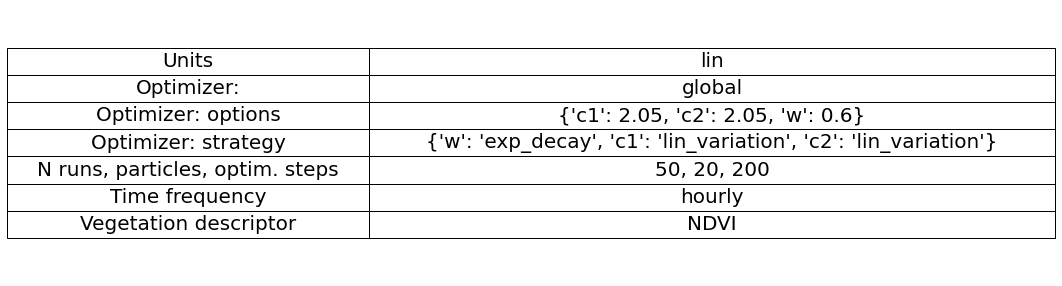

In [80]:
if automate: opt_save_table = True
else: opt_save_table = True if input('Save table with machine params? [y/n]')=='y' else False

fig, ax = plt.subplots(figsize=(14,5))
row_height=0.1; col_width=0.7

# Table with machine, inputs params
timing = 'daily' if freq=='d' else 'hourly'
cellText = [
    ['Units', units],
    # ['Cost function', opt_cost],
    # ['Calib on', opt_calib],
    ['Optimizer:', optim],
    ['Optimizer: options', options],
    ['Optimizer: strategy', oh_strategy],
    ['N runs, particles, optim. steps', str(nrun)+', '+str(n_particles)+', '+str(n_step)],
    ['Time frequency', timing],
    ['Vegetation descriptor', opt_veg],
]
table = ax.table(cellText=cellText,
                     cellLoc='center', loc='center',
                     colLabels=None, rowLabels=None)

for (row, col), cell in table.get_celld().items():
    cell.set_height(row_height)
    cell._loc = 'center'

table.auto_set_font_size(False); table.set_fontsize(20)
table.auto_set_column_width(col=[x for x in range(len(PAR_dict))])
ax.axis('tight'); ax.axis('off')

if opt_save_table: plt.savefig(f'Plot\\{timestr}_table_mach.png', dpi=100)
plt.show()

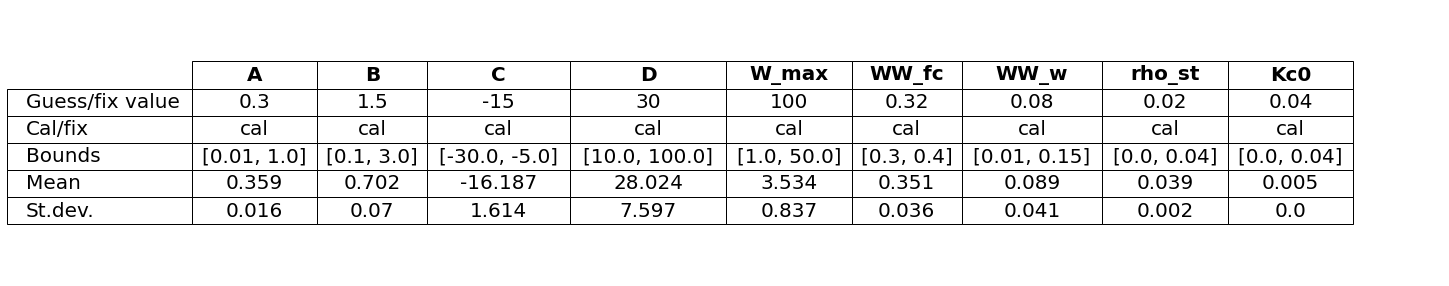

In [81]:
if automate: opt_save_table = True
else: opt_save_table = True if input('Save table with params? [y/n]')=='y' else False

fig, ax = plt.subplots(figsize=(24,5))
row_height=0.1; col_width=0.1

# Table with params
cellText = [[PAR_dict[label][i] for label in PAR_dict] for i in range(5)]
colLabels = [x for x in PAR_dict]
rowLabels = ['Guess/fix value', 'Cal/fix', 'Bounds', 'Mean', 'St.dev.']

#---------------------------------
table = ax.table(cellText=cellText,
                  cellLoc='center', loc='center',
                  colLabels=colLabels,
                  rowLabels=rowLabels,
                )

for (row, col), cell in table.get_celld().items():
    if row == 0: # or col == 0:
        cell.set_text_props(weight='bold')
    cell.set_height(row_height)
    cell._loc = 'center'

table.auto_set_font_size(False); table.set_fontsize(20)
table.auto_set_column_width(col=[x for x in range(len(PAR_dict))])
ax.axis('tight'); ax.axis('off')

if opt_save_table: plt.savefig(f'Plot\\{timestr}_table.png')
plt.show()

In [72]:
if automate: opt_save=True
else: opt_save = True if input('Save log with parameters\' values? [y/n]')=='y' else False

if opt_save:
    for label in PAR_dict:
        i = PARn_str.index(label)
        PAR_dict[label].append(matrix[i])
        # PAR_dict['index'] = ['Guess/fix value', 'Cal/fix', 'Bounds', 'Mean', 'St.dev.','Values']
        pd.DataFrame.from_dict(PAR_dict).set_index('index').to_csv(timestr+'_params.txt', sep=',')

ValueError: All arrays must be of the same length

## Triple plot SM+$\sigma^0$+inputs

RMSE = 1.4466232863674138
R= 0.7013452045110978
bias = -0.5354815901217391
KGE= 0.6923474414136968
RMSE = 0.06424285936115334
R (sim vs obs) = 0.6601752294493323


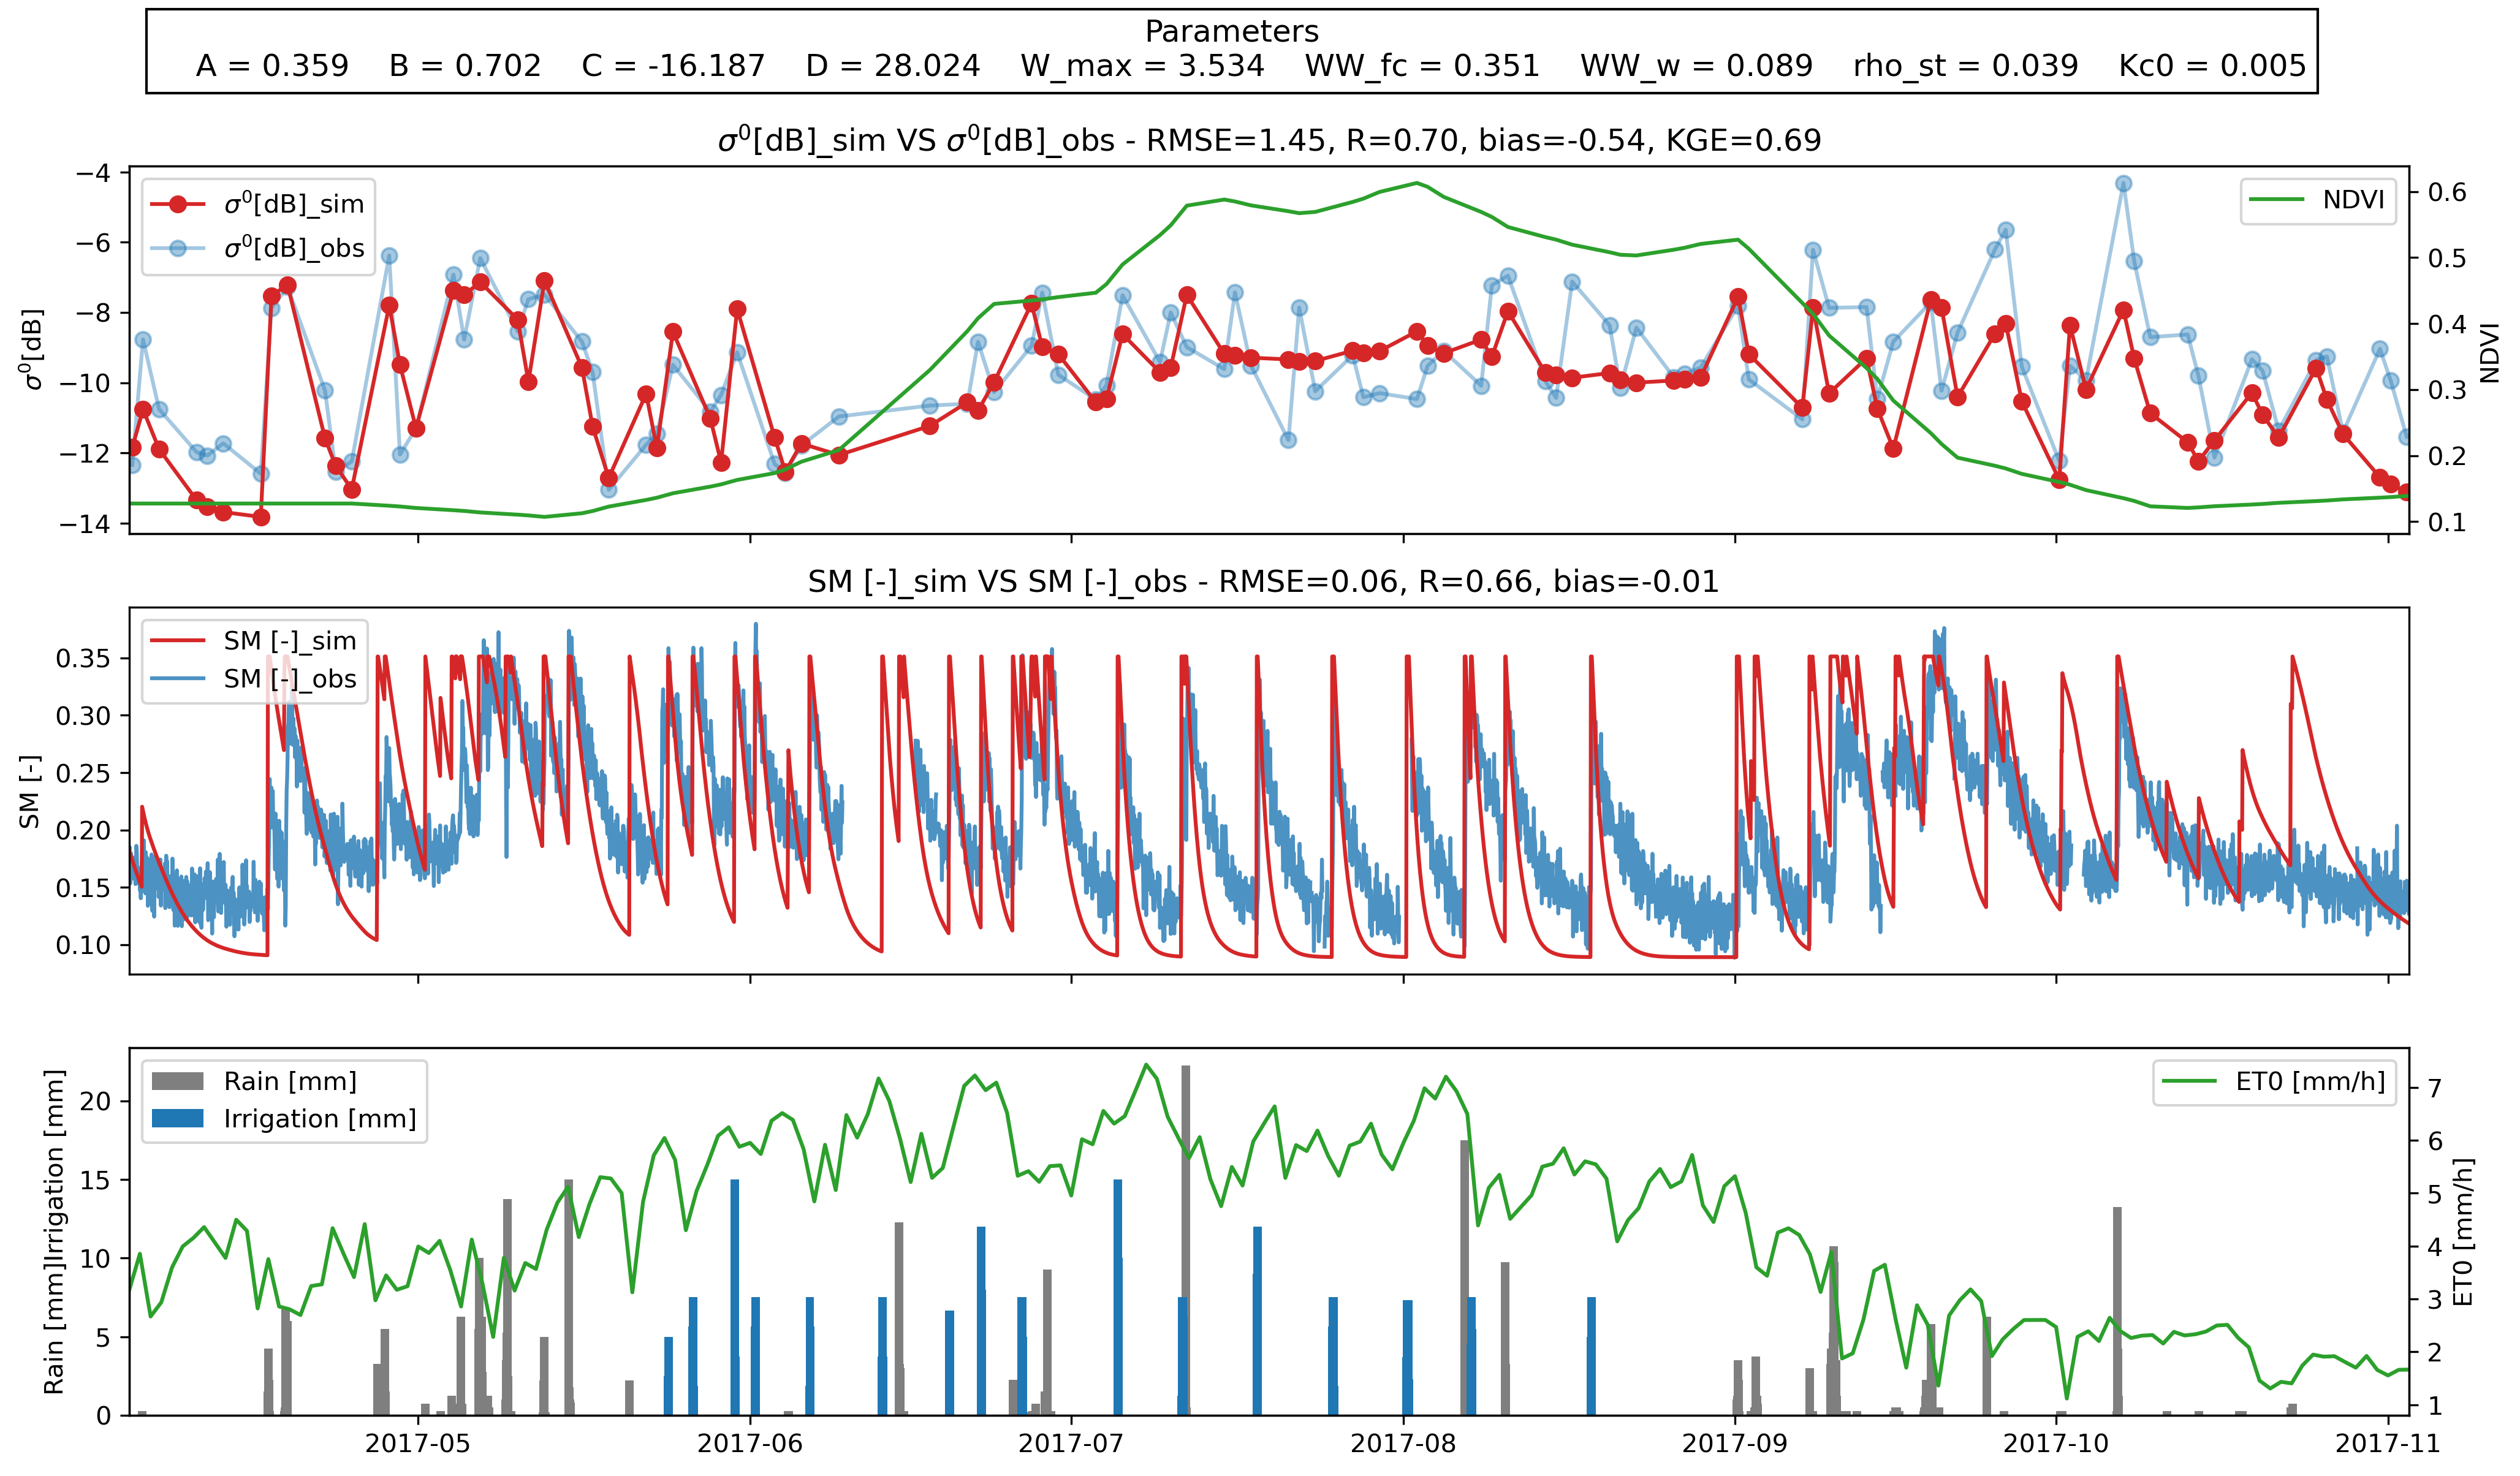

In [82]:
#-----------------------------------------------------------------------
# Triple plot

if automate: opt_save = True
else: opt_save = True if input('Save triple plot SM+s0+inputs? [y/n]')=='y' else False

fig, ax = plt.subplots(3, 1,constrained_layout=False,figsize=(16, 9), sharex=True,dpi=300,)
filename = f'triple_'+units+'_'+PAR_str_add

#----------------------------------------------------------------------------
# Box with params

PAR_text='Parameters\n'
try:
    for i in range(len(PAR_str)): PAR_text+=f'    {PAR_str[i]} = {PAR_tot[i]}'
except NameError:
    for label in PAR_dict: PAR_text+=f'    {label} = {PAR_dict[label][3]}'

fig.text(0.5, 0.95,
         PAR_text, ha='center', va='center',
         bbox={'facecolor':'white', 'edgecolor':'black'},
         transform=fig.transFigure,
         fontsize='large',
        )


def bias(obs, sim):
    """distance between obs' and sim's mean values"""
    if len(obs)==len(sim):
        return np.mean(obs-sim)
    else: raise ValueError(
        f'obs and sim must have same first dimension, but have shapes {np.shape(obs)} and {np.shape(sim)}')
    
#-----------------------------------------------------------------------
plot_triple(fig, ax, times1=t_sat, data1=[VV, sigma0], data1_label=r'$\sigma^0$[dB]', 
            input1=veg, input1_label=opt_veg,
            times2=t, data2=[WW_obs, WW], data2_label='SM [-]',
            input2=[], input2_label='',
            times3=t, data3=[P, IRR_obs, EPOT],
            data3_label=['Rain [mm]', 'Irrigation [mm]', 'ET0 [mm/h]'],
            user_input=[irri],
           )

name=''
if opt_save:
    optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
    name = timestr+filename # +f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
    plt.savefig('Plot\\'+name+'.png')

plt.show()

## Scatterplot

RMSE = 0.06424285936115334
R= 0.6601752294493325 R^2= 0.4358313335784788
bias= -0.005476876236465506


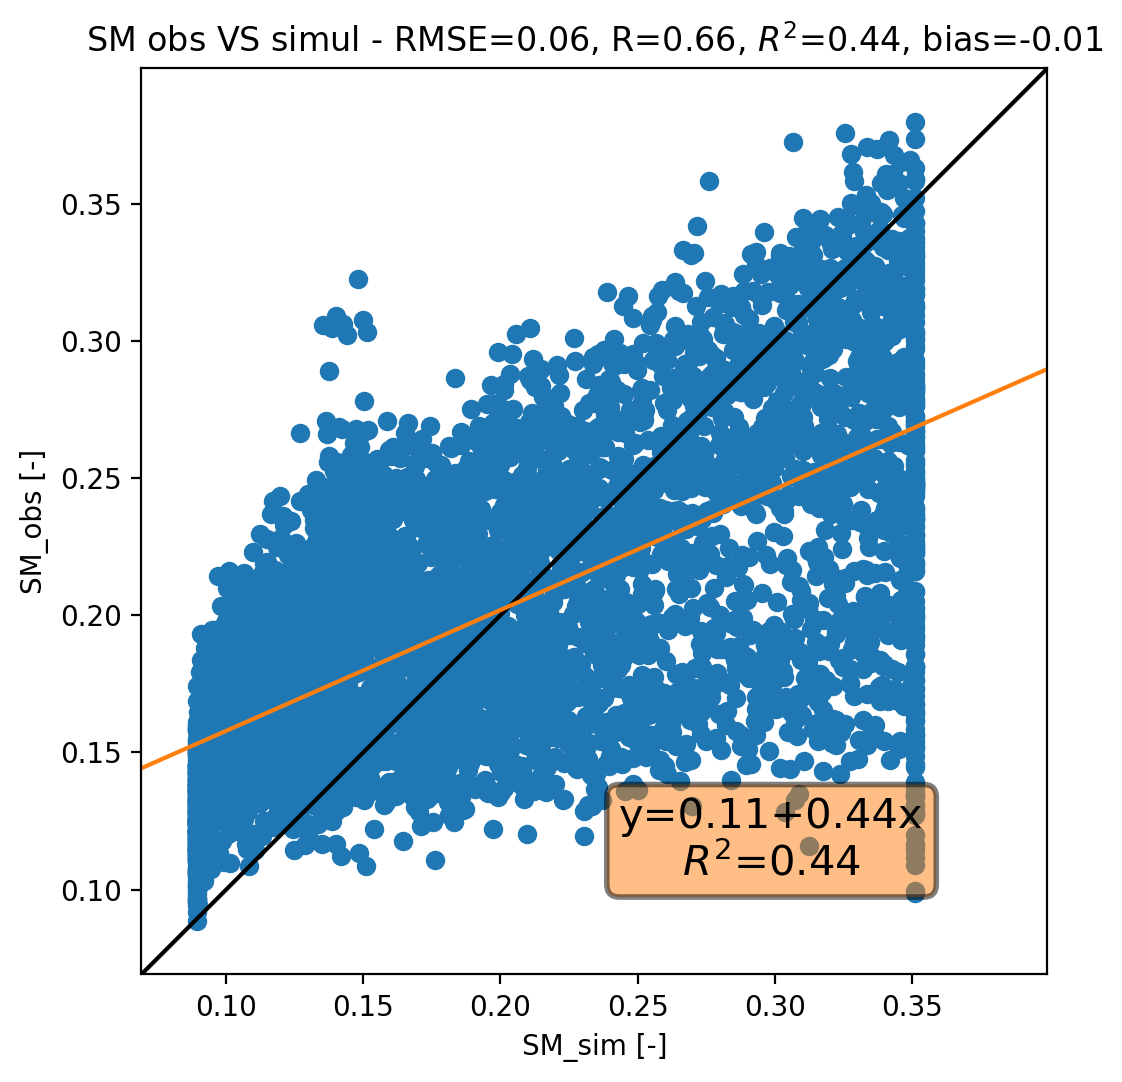

In [83]:
if automate: opt_save = True
else: opt_save = True if input('Save scatterplot of SM? [y/n]')=='y' else False

filename = f'scatter_'+'sm_'+units+PAR_str_add # 'SM'

plot_sim_vs_obs(sim=WW, obs=WW_obs, quantity='SM', um='[-]')
    
if opt_save: plt.savefig('Plot\\'+timestr+'_'+filename+'.png')

RMSE = 1.4466232863674138
R= 0.7013452045110978 R^2= 0.49188509589071366
bias= -0.5354815901217391


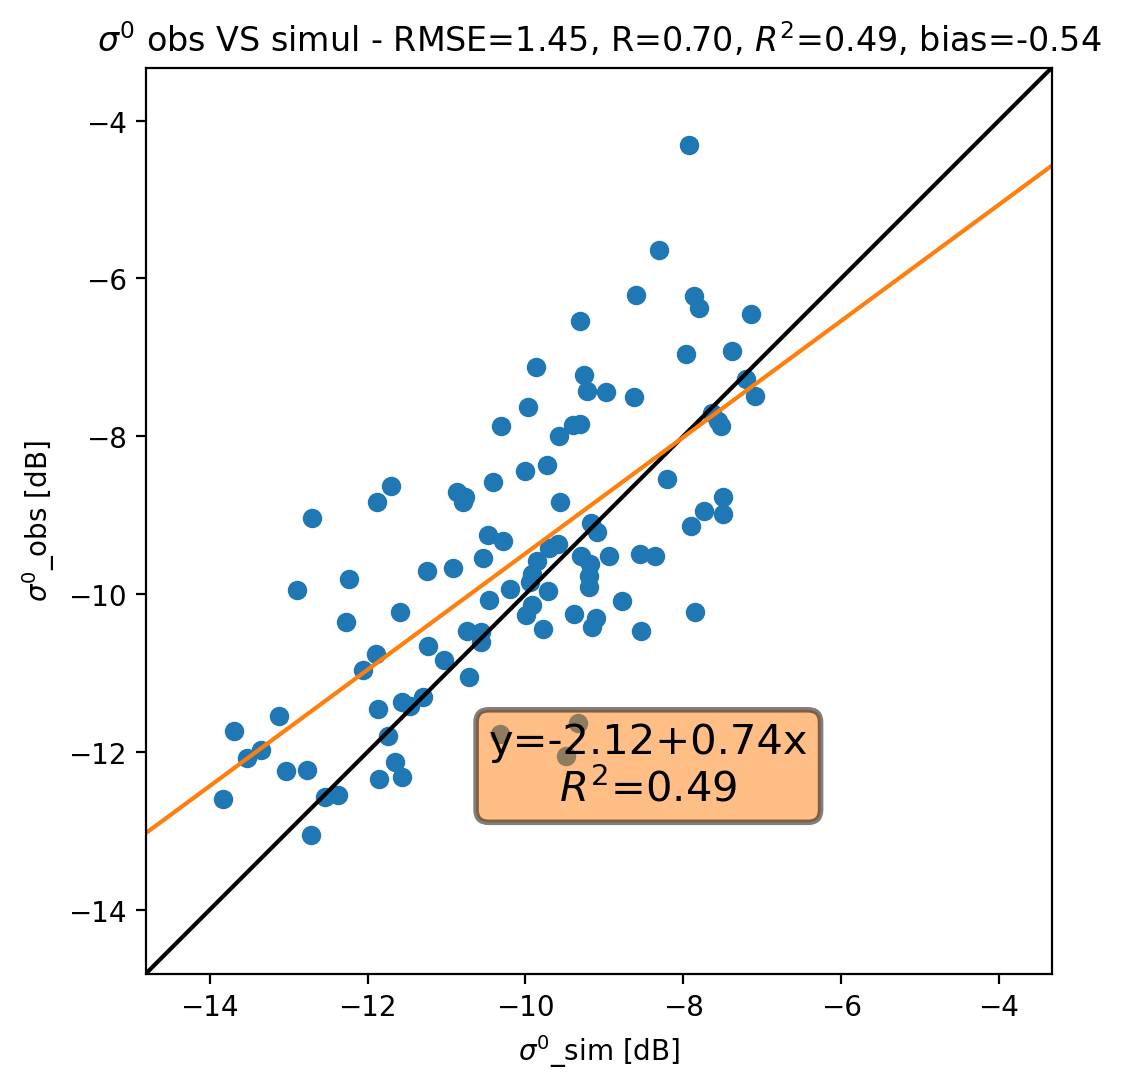

In [84]:
if automate: opt_save = True
else: opt_save = True if input('Save scatterplot of SM? [y/n]')=='y' else False

filename = f'scatter_'+'sigma0_'+units+PAR_str_add # 'sigma0'

plot_sim_vs_obs(sim=sigma0, obs=VV, quantity=r'$\sigma^0$', um='[dB]')
    
if opt_save: plt.savefig('Plot\\'+timestr+'_'+filename+'.png')

# Playground!